In [1]:
from dotenv import load_dotenv
load_dotenv() # load the HF_TOKEN stored in .env file

True

In [ ]:
!nvidia-smi # check for the nvidia systems management interface

In [ ]:
!pip install -U -q accelerate transformers bitsandbytes
!pip install -q git+https://github.com/huggingface/diffusers

In [2]:
import torch
import gc

def flush():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_peak_memory_stats()

flush()

/home/mgurung/workspace/ai/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [3]:
from transformers import T5EncoderModel

ckpt_4bit_id = "sayakpaul/flux.1-dev-nf4-pkg"

text_encoder_2_4bit = T5EncoderModel.from_pretrained(
    ckpt_4bit_id,
    subfolder="text_encoder_2"
)

/home/mgurung/workspace/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [4]:
from diffusers import FluxPipeline, FluxTransformer2DModel

ckpt_id = "black-forest-labs/FLUX.1-dev"

pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder_2=text_encoder_2_4bit,
    transformer=None,
    vae=None,
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

2024-10-21 21:10:35.374478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 21:10:35.387519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 21:10:35.391503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 21:10:35.402960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 21:10:36.173392: W tensorflow/compiler/tf2

In [5]:
prompt = "a red panda in mountain"

with torch.no_grad():
  print("Encoding prompts")
  prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
      prompt = prompt, prompt_2=None, max_sequence_length=256
  )

pipeline = pipeline.to("cpu")
del pipeline
flush()

print(f"prompt_embeds shape: {prompt_embeds.shape}")
print(f"pooled_prompt_embeds shape: {pooled_prompt_embeds.shape}")

Encoding prompts
prompt_embeds shape: torch.Size([1, 256, 4096])
pooled_prompt_embeds shape: torch.Size([1, 768])


/home/mgurung/workspace/ai/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [6]:
transformer_4bit = FluxTransformer2DModel.from_pretrained(ckpt_4bit_id, subfolder="transformer")
pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder=None,
    text_encoder_2=None,
    tokenizer=None,
    tokenizer_2=None,
    transformer=transformer_4bit,
    torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 28.77it/s]


#### Model Running ####


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


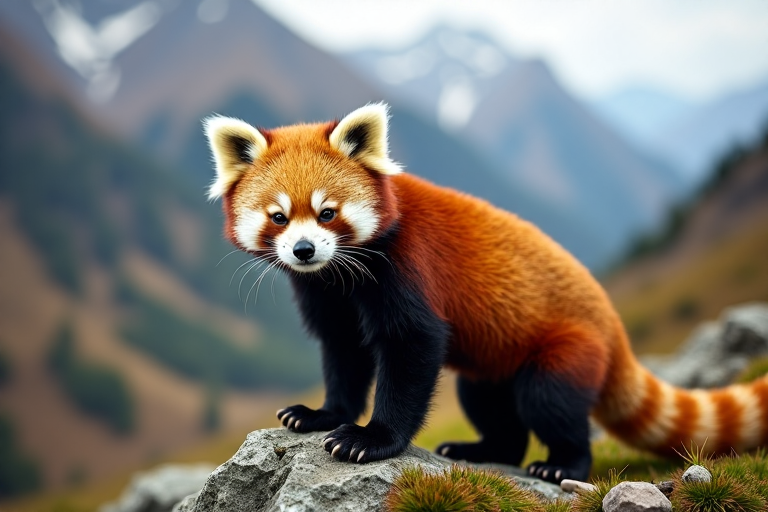

In [7]:
print("#### Model Running ####")
height, width = 512, 768
images = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=50,
    guidance_scale=5.5,
    height=height,
    width=width,
    output_type="pil").images

images[0].save("output.png")

from PIL import Image
Image.open("output.png")